In [148]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.api import add_constant
from ISLP import load_data
from ISLP.models import (
    ModelSpec,
    summarize,
)
from ISLP import confusion_table
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, roc_auc_score

In [149]:
stock_market_data = load_data("Smarket")
print(stock_market_data.shape)
stock_market_data

(1250, 9)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


## 逻辑回归

我们将拟合一个逻辑回归模型，以 `Lag1` 到 `Lag5` 和 `Volume` 为预测变量来预测 `Direction`。可以使用 `sm.GLM()` 函数拟合广义线性模型（generalized linear models），其中包含逻辑回归。另外，`sm.Logit()` 函数也可以直接拟合逻辑回归模型。`sm.GLM()` 的语法与 `sm.OLS()` 类似，但需要添加参数 `family=sm.families.Binomial()`，以指示 `statsmodels` 执行逻辑回归，而不是其他类型的广义线性模型。

In [150]:
x = stock_market_data["Lag1"]
x = add_constant(x)

y = stock_market_data.Direction == "Up"

glm = sm.GLM(y, x, family=sm.families.Binomial())
results = glm.fit()

#### **理解贝塔系数（Coefficients）**

拟合模型后，我们得到系数（或称 **betas**），这些系数指示每个预测变量与市场上升的 **对数几率（log-odds）** 之间的关系。逻辑回归模型的表达式如下：

$$
\log\left(\frac{p}{1 - p}\right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_k X_k
$$

其中：
- $p$ 表示市场上升的概率；
- $\frac{p}{1 - p}$ 表示市场上升的 **几率（odds）**；
- $\log\left(\frac{p}{1 - p}\right)$ 是市场上升的 **对数几率（log-odds）**。

每个系数 $\beta_i$ 表示在保持其他预测变量不变的情况下，预测变量 $X_i$ 增加一个单位时，市场上升的对数几率的 **变化**。

In [151]:
summarize(results)

,coef,std err,z,P>|z|
const,0.0740,0.057,1.306,0.191
Lag1,-0.0702,0.050,-1.404,0.160


在此模型中，最小的p值对应于预测变量 `Lag1`。该变量的负系数表明，如果市场前一天获得了正回报，则当天上升的可能性较低。然而，p值为 `0.15`，表明这一结果在统计上并不显著，因此没有强有力的证据表明 `Lag1` 与 `Direction` 之间存在真实关系。我们可以使用拟合结果的 `params` 属性来获取模型的系数及其对应的p值。

In [152]:
print(
    "beta_hat values\n" "-----------\n",
    results.params,
)
print(
    "\n" "p-values\n" "--------\n",
    results.pvalues,
)

beta_hat = results.params.values

beta_hat values
-----------
 const    0.074011
Lag1    -0.070231
dtype: float64

p-values
--------
 const    0.191418
Lag1     0.160424
dtype: float64


#### **解释系数**

正系数（$\beta_i > 0$）表示，当预测变量 $X_i$ 增加时，市场上升的对数几率（log-odds）以及上升的概率都会增加。负系数则表示，当 $X_i$ 增加时，市场上升的概率会降低。

我们可以使用 `predict()` 方法来估计市场上升的概率，基于当前的预测变量进行预测。如果没有提供新数据，则会对训练集进行概率预测。此外，还可以使用 `exog` 参数传入设计矩阵来预测新数据的概率。

In [153]:
func_lr = 1 / (1 + np.exp(-x @ beta_hat))
print(func_lr.values[:6])

probs = results.predict()
print(probs[:6])

[0.51181103 0.50166485 0.50038315 0.5294072  0.50772166 0.51475864]
[0.51181103 0.50166485 0.50038315 0.5294072  0.50772166 0.51475864]


要预测市场在某一天是会上涨还是下跌，我们需要将预测的概率转换为分类标签（Up或Down）。以下命令通过检查市场上涨的预测概率是否高于或低于0.5来创建分类预测。

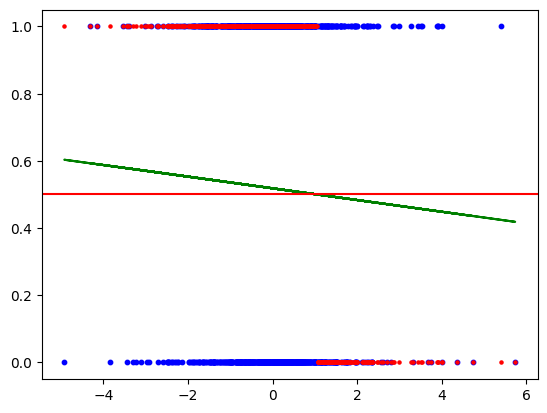

In [154]:
labels = np.array(["Down"] * 1250)
threshold = 0.5
labels[probs > threshold] = "Up"

plt.scatter(x["Lag1"], y, c="b", s=10)
plt.plot(x["Lag1"], probs, "g")
plt.scatter(x["Lag1"], labels == "Up", c="r", s=5)
plt.axhline(y=threshold, color="r", linestyle="-")
plt.show()

/tmp/ipykernel_188224/572886167.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", num_threshold)


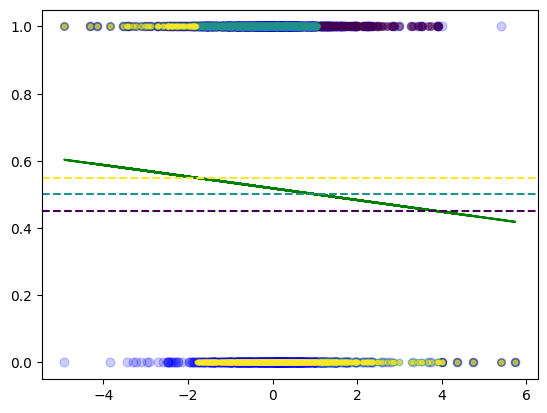

In [155]:
thresholds = np.asarray([0.45, 0.5, 0.55])
num_threshold = len(thresholds)


cmap = cm.get_cmap("viridis", num_threshold)
colors = [cmap(i) for i in range(num_threshold)]
marker_scale = 10

plt.scatter(x["Lag1"], y, c="b", s=marker_scale * (num_threshold + 1), alpha=0.2)
plt.plot(x["Lag1"], probs, "g")

for i, threshold in enumerate(thresholds):
    labels = np.array(["Down"] * 1250)
    labels[probs > threshold] = "Up"

    markersize = marker_scale * (num_threshold - i)
    plt.scatter(
        x["Lag1"],
        labels == "Up",
        color=colors[i],
        s=markersize,
        label=f"Threshold {threshold:.2f}",
        alpha=0.5,
    )
    plt.axhline(y=threshold, color=colors[i], linestyle="--")

#### **系数的指数化（几率比）**

为了使系数更易于解释，我们可以对它们进行指数化，得到 **几率比（odds ratios）**：

$$
\text{几率比} = e^{\beta_i}
$$

- 如果 $e^{\beta_i} > 1$，则增加 $X_i$ **提高** 市场上升的几率。
- 如果 $e^{\beta_i} < 1$，则增加 $X_i$ **降低** 市场上升的几率。

此变换可以更直观地解释每个预测变量对市场上升可能性的影响。

In [156]:
print(f"beta_hat_Lag1 = {beta_hat[1]}")
print(f"OR: exp(beta_hat_Lag1) = {np.exp(beta_hat[1])}")

beta_hat_Lag1 = -0.07023089930744526
OR: exp(beta_hat_Lag1) = 0.9321785556718034


`ISLP` 包中的 `confusion_table()` 函数通过显示正确或错误分类的观测数量来总结预测结果。该函数基于 `sklearn.metrics` 中的类似功能进行修改，将矩阵转置并添加行和列标签。此函数的第一个参数为预测标签，第二个参数为真实标签。

In [157]:
allvars = stock_market_data.columns.drop(["Today", "Direction", "Year"])

design = ModelSpec(allvars)
x = design.fit_transform(stock_market_data)

y = stock_market_data.Direction == "Up"

glm = sm.GLM(y, x, family=sm.families.Binomial())
results = glm.fit()

probs = results.predict()

labels = np.array(["Down"] * 1250)
labels[probs > 0.5] = "Up"

confusion_table(labels, stock_market_data.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


混淆矩阵的对角线元素表示正确的预测，而非对角线元素表示错误。在我们的模型中，市场在 `507` 天被正确预测为上涨，在 `145` 天被正确预测为下跌，总共 `652` 个正确预测。准确率可以通过 `np.mean()` 函数来计算。此处，逻辑回归模型对市场走势的预测准确率为 `52.2%`。

In [158]:
(507 + 145) / 1250, np.mean(labels == stock_market_data.Direction)

(0.5216, 0.5216)

乍一看，逻辑回归模型的表现似乎比随机猜测略好。然而，这一结果具有误导性，因为模型在相同的 `1,250` 个观测数据上进行了训练和测试，导致 `47.8%` 的训练错误率。训练误差往往会低估模型在真实世界中的表现。为了更准确地评估模型，我们可以在部分数据上拟合模型，并在留出的数据（如 `2005` 年的观测数据）上测试。这种方法能更真实地衡量模型未来的预测准确性。

In [159]:
train = stock_market_data.Year < 2005
stock_market_train = stock_market_data.loc[train]
stock_market_test = stock_market_data.loc[~train]
print(stock_market_test.shape)
test_len = stock_market_test.shape[0]

(252, 9)


我们现在在 `2005` 年之前的数据上拟合逻辑回归模型，并使用该模型预测 `2005` 测试集中的股市上涨概率。

In [160]:
x_train, x_test = x.loc[train], x.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, x_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=x_test)

我们已经在两个不同的数据集上对模型进行了训练和测试：训练集仅包含 `2005` 年之前的日期，而测试集仅包含 `2005` 年的观测数据。最后，我们将 `2005` 年的预测结果与该期间的实际市场走势进行比较。首先，我们将存储测试和训练标签（注意 `y_test` 是二元的）。

In [161]:
directions = stock_market_data.Direction
directions_train, directions_test = directions.loc[train], directions.loc[~train]

In [162]:
labels = np.array(["Down"] * test_len)
labels[probs > 0.5] = "Up"
confusion_table(labels, directions_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [163]:
print(
    f"test accuracy = {np.mean(labels == directions_test):.3} %\n"
    f"error rate = {np.mean(labels != directions_test):.3} %"
)

test accuracy = 0.48 %
error rate = 0.52 %


[       inf 0.52821955 0.52121466 0.51889558 0.51683637 0.51665778
 0.51566877 0.51202188 0.51132798 0.50956797 0.508446   0.50835531
 0.50807231 0.50786024 0.50757365 0.50660137 0.50604836 0.50578871
 0.50566986 0.50531336 0.50529498 0.50518787 0.50505516 0.50468519
 0.50426983 0.50422715 0.5040112  0.50354061 0.50277035 0.50249513
 0.50221601 0.5019997  0.50156948 0.50152497 0.50126923 0.50023765
 0.50018783 0.50004706 0.49982856 0.49942866 0.49921293 0.49919101
 0.49896204 0.49894567 0.49833448 0.49814402 0.49781485 0.49717326
 0.4971474  0.49676599 0.49671242 0.49606301 0.49583069 0.49472492
 0.49461462 0.49408024 0.49400476 0.49399758 0.49383793 0.49372402
 0.4935757  0.49341517 0.49321042 0.49251726 0.49199293 0.49151809
 0.49125768 0.49106893 0.48987588 0.48980104 0.48963306 0.48958355
 0.48843384 0.48818721 0.48806083 0.48774809 0.48763474 0.48758656
 0.4873724  0.48623326 0.48585567 0.48581824 0.48549859 0.48397481
 0.48395853 0.48389011 0.48381536 0.48322119 0.48159807 0.4815

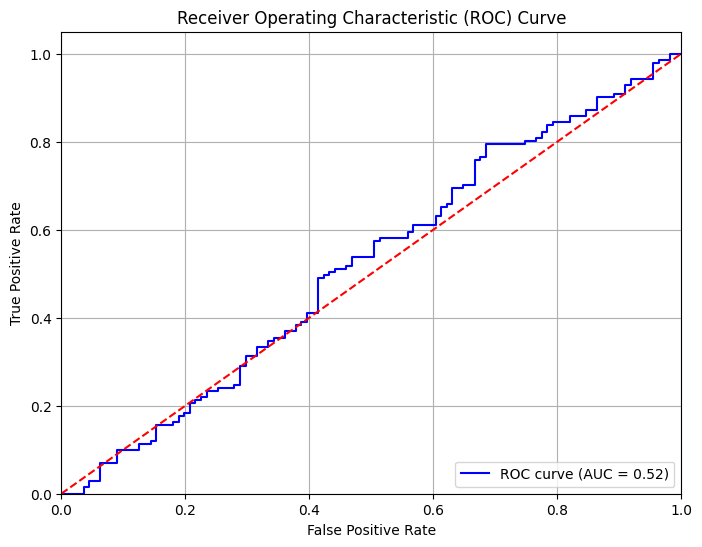

In [164]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
print(thresholds)
print(thresholds.shape)
# Compute the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {auc:.2f})")
plt.plot(
    [0, 1], [0, 1], color="red", linestyle="--"
)  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()

如果我们希望基于特定的 `Lag1` 和 `Lag2` 值来预测市场回报，可以使用 `predict()` 函数。具体来说，我们将预测以下情境中的 `Direction`：

1. 当 `Lag1` 为 `1.2` 且 `Lag2` 为 `1.1` 时。
2. 当 `Lag1` 为 `1.5` 且 `Lag2` 为 `-0.8` 时。

通过将这些值传递给 `predict()` 函数，我们可以获得在这些日期的 `Direction` 的相应预测结果。

In [165]:
new_data = pd.DataFrame(
    {
        "Lag1": [1.2, 1.5],
        "Lag2": [1.1, -0.8],
    }
)
# new_x = glm.transform(new_data)
# results.predict(new_x)